# <h1 align=center>Emotion Recognition</h1>

In [6]:
# importando dependencias de trabajo
# importando librerias basicas
import os
import sys
import re
import gc

# importando modulos de analisis de datos, ML y graficas
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from collections import Counter

# importando dependencias para tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# importando para sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# importando para modelos de keras
from keras.models import Model
# from keras.models import Sequential
# importando para keras capas
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
# from keras.layers import MaxPooling2D
# from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from imblearn.over_sampling import SMOTE

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Rescaling, InputLayer, MaxPool2D, BatchNormalization, Dropout, RandomFlip, RandomRotation, RandomContrast, RandomZoom, Resizing
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix
import cv2
import seaborn as sns
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
import kagglehub
import pathlib
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import shutil
import random
import cv2
import numpy as np
import tensorflow as tf


## Funciones Utiles

In [7]:
# funcion que recibe una lista numpy y recupera la forma de cada elemento, devuelve una lista con formas
def get_shape(data):
    # respuesta de la funcion
    ans = list()

    for d in data:
        sp = d.shape
        ans.append(sp)
    return ans

In [8]:
# funcion que transforma el entero de la clase a la palabra de la etiqueta, devuelve una lista de etiquetas
def class2label(data, labels):
    # respuesta de la funcion
    ans = list()

    for d in data:
        d = int(d)
        l = str(labels[d])
        ans.append(l)
    return ans

In [9]:
# funcion que estandariza los datos en numpy de acuerdo a un valor min & max, devuelve un arreglo np flotante
def std_data(data, minv, maxv):
    rangev = maxv - minv
    ans = data.astype("float32")/float(rangev)
    # ans = pd.Series(ans)
    # respuesta de la funcion
    return ans

## Cargar y Preparar los Datos

Los pasos de esta seccion son:

1. Leer los datos de la carpeta
2. Formatear los datos para que los acepte el DataFrame de Pandas.
2. Crear el DataFrame de Pandas con un esquema propio.
2. Formatear los datos para pobrar el DataFrame de pandas.
3. Revisar que todo este como deberia estar.

In [10]:
# Directorios para train y test (actualizados)
#train_directory = 'faces/train'
#val_directory = 'faces/test'

train_directory = "EmotionsDataset_Splitted/train"
val_directory = "EmotionsDataset_Splitted/test"

In [11]:
# lista de nombres de las clasificaciones de emociones
label_names = [     # label number
    "angry",        # 0
    "happy",        # 1
    "sad",          # 2
    "nothing",      # 3
]

In [12]:
# Image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32

In [13]:
# nombres de columnas para el dataframe de pandas
col_names = [           # nombre de columna DF
    "img_data",         # datos de la imagen
    "img_shape",        # forma de la imagen
    "class",            # clase de la imagen, de 0 a 9
    "label",            # nombre de la clase
    "std_img_data",     # datos de la imagen estandarizados
    "cat_labels"        # etiquetas categoricas de la clase
]
# "ReshapeData", "Label", "Class", "DataSize", "ReshapeSize", "ResKeras", "ScoreKeras"]
# creando dataframe con columnas vacio
emotions_df = pd.DataFrame(columns=col_names)

In [14]:
# Cargar conjuntos de datos desde los directorios
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='int',  # Etiquetas enteras (0, 1, 2, 3 según el orden en label_names)
    class_names=label_names,  # Nombres de las clases
    image_size=(img_height, img_width),  
    batch_size=batch_size,
    shuffle=True
)

Found 2967 files belonging to 4 classes.


In [15]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='int',  # Etiquetas enteras
    class_names=label_names,
    image_size=(img_height, img_width),  
    batch_size=batch_size,
    shuffle=True
)

Found 788 files belonging to 4 classes.


In [ ]:
# Adjusted face detection function
def detect_faces(image_tensor):
    # Convert tensor to numpy array if necessary (outside graph context)
    image = image_tensor.numpy()  # Ensure this is done in eager execution

    # Perform face detection with OpenCV (assuming you have a pre-trained model for detection)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return faces

# Modify the dataset mapping
def map_function(x, y):
    # Assuming 'x' is an image tensor and 'y' is the label
    faces = detect_faces(x)
    return faces, y

# Apply the map function to the dataset
train_dataset = train_dataset.map(map_function)
val_dataset = val_dataset.map(map_function)



In [17]:
# Filtrar imágenes con rostros detectados
train_dataset = train_dataset.map(lambda x, y: (detect_faces(x), y))
val_dataset = val_dataset.map(lambda x, y: (detect_faces(x), y))

# Filtrar las imágenes que tienen un rostro
train_dataset = train_dataset.filter(lambda x, y: x is not None)
val_dataset = val_dataset.filter(lambda x, y: x is not None)

NotImplementedError: in user code:

    File "C:\Users\Valentina\AppData\Local\Temp\ipykernel_12952\471820158.py", line 2, in None  *
        lambda x, y: (detect_faces(x), y)
    File "C:\Users\Valentina\AppData\Local\Temp\ipykernel_12952\3344140372.py", line 4, in detect_faces  *
        image_bgr = np.array(image)

    NotImplementedError: Cannot convert a symbolic tf.Tensor (args_0:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.


In [ ]:
# Convertir dataset a NumPy para trabajar con SMOTE
def dataset_to_numpy(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    return np.concatenate(images, axis=0), np.concatenate(labels, axis=0)

In [ ]:
x_train, y_train = dataset_to_numpy(train_dataset)
x_val, y_val = dataset_to_numpy(val_dataset)

In [ ]:
# Mostrar distribución de clases antes del balanceo
print("Distribución inicial de clases (entrenamiento):", np.bincount(y_train))
print("Distribución inicial de clases (validación):", np.bincount(y_val))

Distribución inicial de clases (entrenamiento): [850 830 413 874]
Distribución inicial de clases (validación): [213 207 149 219]


In [ ]:
# Aplanar imágenes para aplicar SMOTE
x_train_flat = x_train.reshape(x_train.shape[0], -1)

In [ ]:
# Aplicar SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train)

In [ ]:
# Convertimos de nuevo X_resampled a la forma de imágenes 128x128 para el modelo de CNN
x_train_resampled = x_train_resampled.reshape(1, 128, 128, 1)

In [ ]:
# Verificar distribución de clases después del balanceo
print("Distribución balanceada de clases (entrenamiento):", np.bincount(y_train_resampled))

Distribución balanceada de clases (entrenamiento): [874 874 874 874]


In [ ]:
# Convertir etiquetas a categóricas (one-hot encoding) si se necesita para la red
y_train_categorical = tf.keras.utils.to_categorical(y_train_resampled, num_classes=len(label_names))
y_val_categorical = tf.keras.utils.to_categorical(y_val, num_classes=len(label_names))

In [ ]:
# Verificar formas de los datos
print("Forma de x_train_resampled:", x_train_resampled.shape)
print("Forma de y_train_categorical:", y_train_categorical.shape)
print("Forma de x_val:", x_val.shape)
print("Forma de y_val_categorical:", y_val_categorical.shape)

Forma de x_train_resampled: (3496, 128, 128, 1)
Forma de y_train_categorical: (3496, 4)
Forma de x_val: (788, 128, 128, 1)
Forma de y_val_categorical: (788, 4)


In [ ]:
# Recuperar forma de las imágenes
img_shape = x_train_resampled.shape[1:]

# Recuperar etiquetas de las clases
labels = [label_names[label] for label in y_train_resampled]

# Establecer datos estandarizados
scaler = StandardScaler()
x_train_resampled_flat = x_train_resampled.reshape(x_train_resampled.shape[0], -1)
std_img_data = scaler.fit_transform(x_train_resampled_flat)

# Categorizando las clases a aprender
cat_labels = to_categorical(y_train_resampled, len(label_names))

In [ ]:
# Convertir datos a listas para agregarlos al DataFrame
img_data = x_train_resampled.tolist()
std_img_data = std_img_data.tolist()
cat_labels = cat_labels.tolist()

In [ ]:
class_data =y_train_resampled
img_shape = [img_shape] * len(img_data)

# definir arreglo basico de datos
data_lt = (
    img_data,       # datos de la imagen   0
    img_shape,      # forma de la imagen   1
    class_data,     # clase de la imagen   2
    labels,         # nombre de la clase   3
    std_img_data,   # datos de la imagen estandarizados 4
    cat_labels,     # etiquetas categoricas de la clase 5
)

In [ ]:
# poblamdo las columnas del dataframe
for col, data in zip(col_names, data_lt):
    emotions_df[col] = data

In [ ]:
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3496 entries, 0 to 3495
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   img_data      3496 non-null   object
 1   img_shape     3496 non-null   object
 2   class         3496 non-null   int32 
 3   label         3496 non-null   object
 4   std_img_data  3496 non-null   object
 5   cat_labels    3496 non-null   object
dtypes: int32(1), object(5)
memory usage: 150.3+ KB


In [ ]:
# imprime el encabezado del dataframe
emotions_df.head()

,img_data,img_shape,class,label,std_img_data,cat_labels
0,"[[[116.53885650634766], [131.32196044921875], ...","(128, 128, 1)",0,angry,"[-0.09633389115333557, 0.10291872173547745, -0...","[1.0, 0.0, 0.0, 0.0]"
1,"[[[236.52459716796875], [238.21658325195312], ...","(128, 128, 1)",0,angry,"[1.4290920495986938, 1.4724780321121216, 1.429...","[1.0, 0.0, 0.0, 0.0]"
2,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...","(128, 128, 1)",3,nothing,"[-1.577938199043274, -1.5796093940734863, -1.5...","[0.0, 0.0, 0.0, 1.0]"
3,"[[[254.97451782226562], [254.97451782226562], ...","(128, 128, 1)",3,nothing,"[1.6636531352996826, 1.6871846914291382, 1.714...","[0.0, 0.0, 0.0, 1.0]"
4,"[[[254.97451782226562], [254.97451782226562], ...","(128, 128, 1)",3,nothing,"[1.6636531352996826, 1.6871846914291382, 1.703...","[0.0, 0.0, 0.0, 1.0]"


In [ ]:
# libero memoria
gc.collect()

0

## Revisando los Datos
Es importante revisar los datos para saber que se esta trabajando con ellos. En esta sección se revisa la forma de los datos, se visualizan algunas imágenes y se revisa la distribución de las clases.

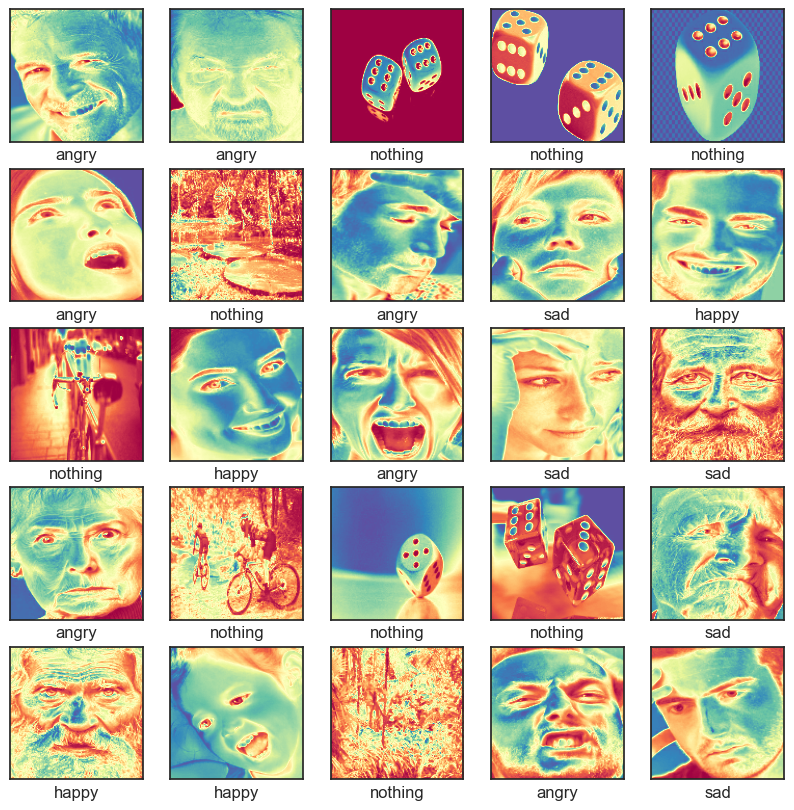

In [ ]:
# pruebo imagenes del dataset
# imagen de 5x5 subplots con tamaño de 10x10
sns.set_theme(style="white")
plt.figure(figsize=(10, 10))
# recorriendo las imagenes
for i in range(25):
    # creando subplots
    plt.subplot(5, 5, i+1)
    # xticks y yticks desactivados
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # tomo la imagen de la columna de datos de la imagen
    # el mapa de colores es viridis de matplotlib
    # otras opciones son: "plasma", "viridis", "BuPu", "hsv", "Spectral"
    plt.imshow(emotions_df["img_data"][i],
               cmap=plt.cm.Spectral)
    # tomo el nombre de la clase de la columna de etiquetas
    plt.xlabel(emotions_df["label"][i])

## Preprocesar los Datos

Los pasos de esta seccion son:

1. Revisar que los datos esten bien.
2. Elegir la caracteristicas o propiedades de aprendizaje.
3. Elegir la variable objetivo del aprendizaje.
4. Dividir la conjunto de datos entre las poblaciones de entrenamiento y pruebas.
5. Formatear los datos de aprendizaje y objetivo acorde a la red neuronal.

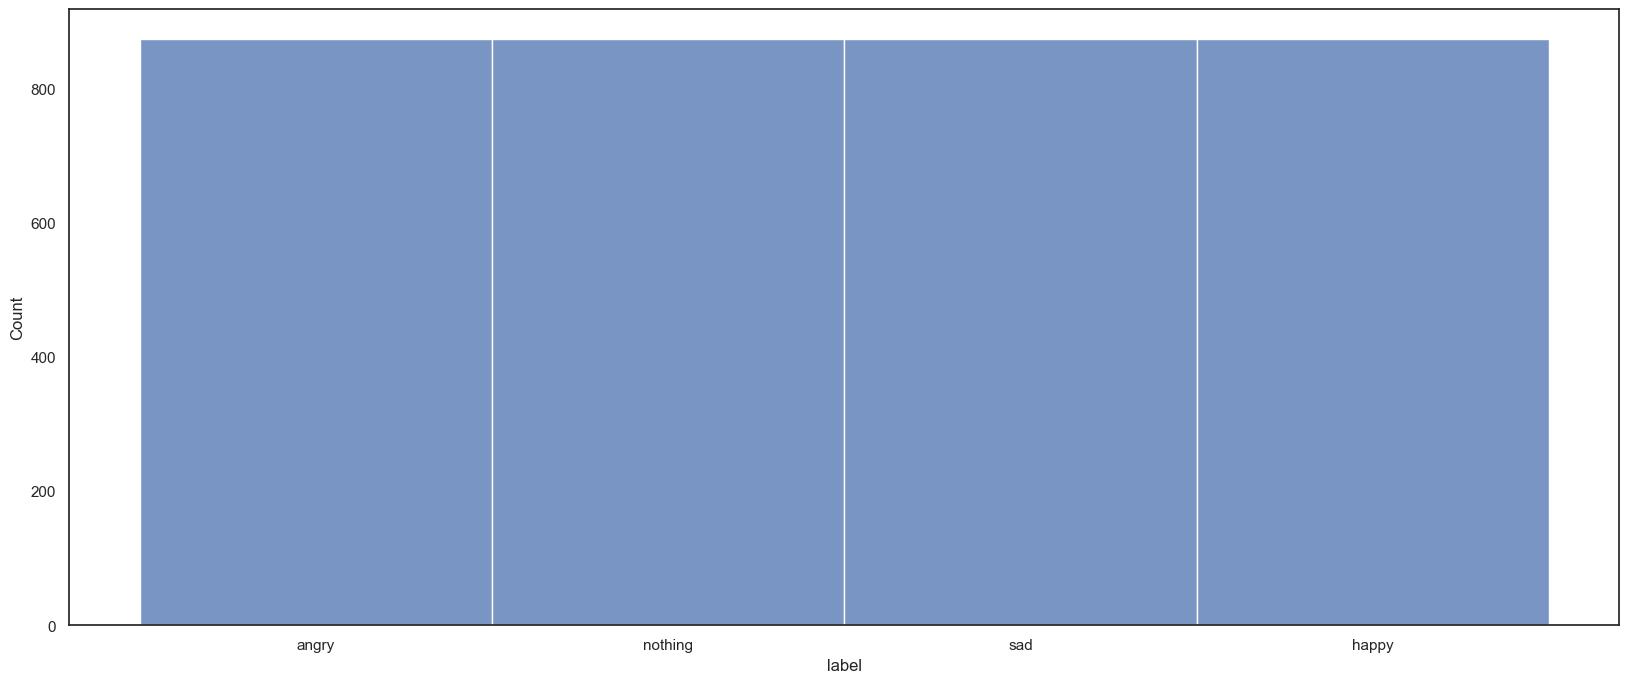

In [ ]:
# cchequeo la distribucion de datos
plt.figure(figsize=(20, 8))
sns.set_theme(style="white")
sns.histplot(emotions_df[col_names[3]])
plt.show()

In [ ]:
# Recuperando las imágenes y categorías estandarizadas
A = emotions_df[col_names[4]]  # Datos de las imágenes estandarizadas
b = emotions_df[col_names[5]].values  # Etiquetas categóricas

In [ ]:
# Convertimos los datos de las imágenes estandarizadas a numpy y las etiquetas a numpy
X = np.array([np.array(i, dtype="object") for i in A])  
y = np.array([np.array(j, dtype="object") for j in b]) 

In [ ]:
# Verifica las formas de X e y
print("Forma de X antes de reshape:", X.shape)
print("Forma de y:", y.shape)

Forma de X antes de reshape: (3496, 16384)
Forma de y: (3496, 4)


In [ ]:
# Verifica que las imágenes tengan la forma correcta
imgsh = X[0].shape  # Forma de la primera imagen

In [ ]:
# Ajuste de la forma de X para que sea compatible con la CNN (128x128x1)
X = X.reshape(emotions_df.shape[0], 128, 128, 1)

# Verifica la nueva forma
print("Forma de X después del reshape:", X.shape)

Forma de X después del reshape: (3496, 128, 128, 1)


In [ ]:
# semilla para el random
rseed = 42

# en tamanho de la muestra para pruebas esta entre 0.2 y 0.3
train_pop = 0.8
test_pop = 1.0 - train_pop

In [ ]:
# distribuir los datos entre entrenamiento vs. pruebas
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = test_pop, random_state = rseed)

In [ ]:
# Formateo para Keras y TensorFlow, usando float32 por eficiencia
X_train = tf.convert_to_tensor(X_train, dtype="float32")
y_train = tf.convert_to_tensor(y_train, dtype="float32")
X_test = tf.convert_to_tensor(X_test, dtype="float32")
y_test = tf.convert_to_tensor(y_test, dtype="float32")

# Verificar las formas de los datos
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (2796, 128, 128, 1)
Forma de y_train: (2796, 4)
Forma de X_test: (700, 128, 128, 1)
Forma de y_test: (700, 4)


#### MODELING

In [ ]:
# Definición de los parámetros del modelo en el diccionario configuration
configuration = {
    "im_size": 128,              # Tamaño de la imagen de entrada (128x128 píxeles)
    "n_filters": 32,             # Número de filtros en la primera capa convolucional
    "kernel_size": (3, 3),       # Tamaño del kernel de la convolución
    "n_strides": (1, 1),         # Tamaño del stride (desplazamiento) en las capas convolucionales
    "pool_size": (2, 2),         # Tamaño de la ventana de max pooling
    "dropout_rate": 0.5,         # Tasa de dropout para regularización
    "regularization_rate": 0.01, # Tasa de regularización L2
    "n_dense_1": 256,            # Número de unidades en la primera capa densa
    "n_dense_2": 128,             # Número de unidades en la segunda capa densa
    "num_classes": 4,            # Número de clases para la clasificación final
    "learning rate": 0.001,      # Tasa de aprendizaje
    "n_epochs": 15,              # Número de épocas
}

In [ ]:
lenet_model = tf.keras.Sequential([

    # Data Augmentation Layer
    RandomFlip("horizontal", input_shape=(configuration["im_size"], configuration["im_size"], 1)),
    RandomRotation(0.2),
    RandomZoom(0.2),

    # First Convolutional Block
    Conv2D(filters=configuration["n_filters"], kernel_size=configuration["kernel_size"],
           strides=tuple(configuration["n_strides"]), padding='same', activation='relu',
           kernel_regularizer=L2(configuration["regularization_rate"])),
    BatchNormalization(),
    MaxPool2D(pool_size=configuration["pool_size"]),
    Dropout(rate=configuration["dropout_rate"]),

    # Second Convolutional Block
    Conv2D(filters=configuration["n_filters"] * 2, kernel_size=configuration["kernel_size"],
           strides=tuple(configuration["n_strides"]), padding='same', activation='relu',
           kernel_regularizer=L2(configuration["regularization_rate"])),
    BatchNormalization(),
    MaxPool2D(pool_size=configuration["pool_size"]),
    Dropout(rate=configuration["dropout_rate"]),

    # Third Convolutional Block (Optional)
    Conv2D(filters=configuration["n_filters"] * 4, kernel_size=configuration["kernel_size"],
           strides=tuple(configuration["n_strides"]), padding='same', activation='relu',
           kernel_regularizer=L2(configuration["regularization_rate"])),
    BatchNormalization(),
    MaxPool2D(pool_size=configuration["pool_size"]),
    Dropout(rate=configuration["dropout_rate"]),

    # Flattening Layer
    Flatten(),

    # Fully Connected Layers
    Dense(configuration["n_dense_1"], activation="relu", kernel_regularizer=L2(configuration["regularization_rate"])),
    BatchNormalization(),
    Dropout(rate=configuration["dropout_rate"]),
    
    Dense(configuration['n_dense_2'], activation="relu", kernel_regularizer=L2(configuration["regularization_rate"])),
    BatchNormalization(),
    Dropout(rate=configuration["dropout_rate"]),

    # Output Layer
    Dense(configuration["num_classes"], activation="softmax"),
])

# Mostrar resumen del modelo
lenet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 128, 128, 1)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             

 Total params: 8,517,380 (32.49 MB)

 Trainable params: 8,516,164 (32.49 MB)

 Non-trainable params: 1,216 (4.75 KB)

#### TRAINING MODEL

In [ ]:
# Definir función de pérdida y métricas
loss_function = tf.keras.losses.CategoricalCrossentropy()
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.TopKCategoricalAccuracy(k=2, name='top_k_accuracy')
]


In [ ]:
# EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [ ]:
# Compilar el modelo
lenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=configuration["learning rate"]),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"])

In [ ]:
# Crear datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(buffer_size=1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Prefetch para optimizar la carga de datos
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Entrenar el modelo
history = lenet_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=configuration["n_epochs"],
    verbose=1,
)

# Guardar el modelo
lenet_model.save("best_emotions_model.keras")

Epoch 1/15


88/88 ━━━━━━━━━━━━━━━━━━━━ 85s 873ms/step - accuracy: 0.4475 - loss: 10.5133 - val_accuracy: 0.2257 - val_loss: 21.2604
Epoch 2/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 75s 849ms/step - accuracy: 0.5201 - loss: 7.8676 - val_accuracy: 0.2257 - val_loss: 17.6807
Epoch 3/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 79s 902ms/step - accuracy: 0.5219 - loss: 6.2430 - val_accuracy: 0.2257 - val_loss: 11.1455
Epoch 4/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 865ms/step - accuracy: 0.5370 - loss: 4.7593 - val_accuracy: 0.2257 - val_loss: 7.9267
Epoch 5/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 78s 883ms/step - accuracy: 0.5647 - loss: 3.9477 - val_accuracy: 0.2300 - val_loss: 6.2256
Epoch 6/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 867ms/step - accuracy: 0.5459 - loss: 3.4769 - val_accuracy: 0.2429 - val_loss: 3.7434
Epoch 7/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 76s 862ms/step - accuracy: 0.5699 - loss: 2.8171 - val_accuracy: 0.4114 - val_loss: 2.9088
Epoch 8/15
88/88 ━━━━━━━━━━━━━━━━━━━━ 77s 879ms/step - accuracy: 0.5803 - loss: 2.5665 - val_accuracy: 0

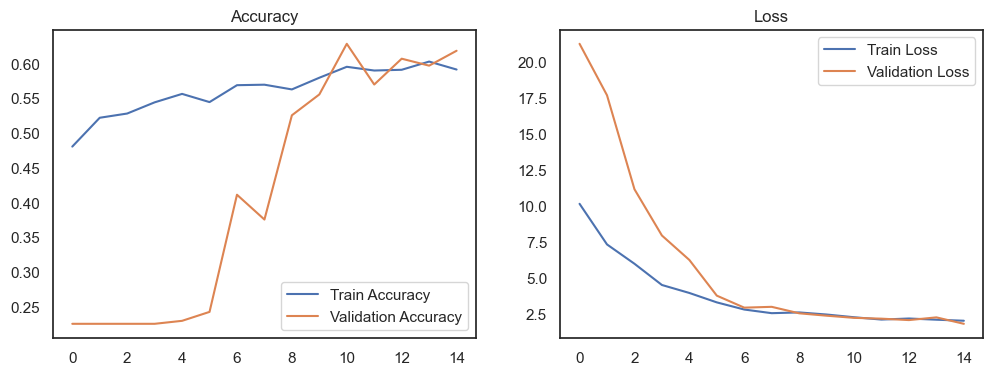

In [ ]:
# Visualización de las métricas de entrenamiento y validación
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

##### TESTING

In [ ]:
import dlib
import cv2
import dlib
import numpy as np
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('best_emotions_model.keras')

# Lista de emociones (asegúrate de que coincidan con las clases del modelo)
emotions = ['happy', 'angry', 'nothing', 'sad']

# Cargar el detector de rostros y el predictor de puntos de referencia faciales
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Función para crear una imagen a partir de los landmarks
def create_landmark_image(landmarks, image_size=128):
    # Crear una imagen negra
    img = np.zeros((image_size, image_size), dtype=np.uint8)

    # Escalar los landmarks a coordenadas de la imagen
    landmarks = np.array(landmarks)
    landmarks[:, 0] *= image_size  # Escalar x
    landmarks[:, 1] *= image_size  # Escalar y

    # Dibujar los puntos en la imagen
    for x, y in landmarks:
        cv2.circle(img, (int(x), int(y)), 2, (255), -1)

    return img

# Captura de video
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros en la imagen
    faces = detector(gray)

    for face in faces:
        # Obtener los landmarks para el rostro detectado
        landmarks = predictor(gray, face)

        # Obtener las coordenadas (x, y) de los landmarks
        landmarks_points = []
        for n in range(68):  # El predictor tiene 68 puntos de referencia
            x = landmarks.part(n).x / frame.shape[1]  # Normalizar coordenadas
            y = landmarks.part(n).y / frame.shape[0]  # Normalizar coordenadas
            landmarks_points.append([x, y])

        # Crear la imagen de los landmarks
        landmark_image = create_landmark_image(landmarks_points)

        # Redimensionar la imagen a 128x128
        landmark_image_resized = cv2.resize(landmark_image, (128, 128))

        # Expandir las dimensiones de la imagen para que tenga el formato (1, 128, 128, 1)
        input_image = np.expand_dims(landmark_image_resized, axis=-1)
        input_image = np.expand_dims(input_image, axis=0)
        input_image = input_image / 255.0  # Normalizar entre 0 y 1

        # Realizar la predicción con el modelo cargado
        output = model.predict(input_image)
        predicted_emotion = emotions[np.argmax(output)]  # Obtener la emoción más probable

        # Mostrar la emoción en la ventana del video
        cv2.putText(frame, f'Emotion: {predicted_emotion}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Mostrar la imagen con el rostro y la emoción
    cv2.imshow("Face Emotion Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 665ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Cargar el modelo
model = load_model('best_emotions_model.keras')

# Lista de emociones (asegúrate de que coincidan con las clases del modelo)
emotions = ['happy', 'angry', 'nothing', 'sad']

# Cargar el clasificador en cascada de Haar para la detección de rostros
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Función para crear una imagen a partir de los landmarks
def create_landmark_image(landmarks, image_size=128):
    # Crear una imagen negra
    img = np.zeros((image_size, image_size), dtype=np.uint8)

    # Escalar los landmarks a coordenadas de la imagen
    landmarks = np.array(landmarks)
    landmarks[:, 0] *= image_size  # Escalar x
    landmarks[:, 1] *= image_size  # Escalar y

    # Dibujar los puntos en la imagen
    for x, y in landmarks:
        cv2.circle(img, (int(x), int(y)), 2, (255), -1)

    return img

# Captura de video
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir la imagen a escala de grises
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros en la imagen
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)  # Parámetros de la detección de rostros

    for (x, y, w, h) in faces:
        # Dibujar un rectángulo alrededor del rostro detectado
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extraer la región de interés (ROI) para los landmarks
        face_region = gray[y:y + h, x:x + w]

        # Crear una imagen de los landmarks (aquí es solo un ejemplo simple de puntos)
        # Podrías agregar un detector de landmarks si tienes uno (por ejemplo, MediaPipe o algún otro)
        landmarks_points = np.random.rand(68, 2)  # Usando valores aleatorios como ejemplo

        # Crear la imagen de los landmarks
        landmark_image = create_landmark_image(landmarks_points)

        # Redimensionar la imagen a 128x128
        landmark_image_resized = cv2.resize(landmark_image, (128, 128))

        # Expandir las dimensiones de la imagen para que tenga el formato (1, 128, 128, 1)
        input_image = np.expand_dims(landmark_image_resized, axis=-1)  # (128, 128, 1)
        input_image = np.expand_dims(input_image, axis=0)  # (1, 128, 128, 1)
        input_image = input_image / 255.0  # Normalizar entre 0 y 1

        # Realizar la predicción con el modelo cargado
        output = model.predict(input_image)
        predicted_emotion = emotions[np.argmax(output)]  # Obtener la emoción más probable

        # Mostrar la emoción en la ventana del video
        cv2.putText(frame, f'Emotion: {predicted_emotion}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # Mostrar la imagen con el rostro y la emoción
    cv2.imshow("Face Emotion Recognition", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Cargar el modelo previamente entrenado (ajusta la ruta del modelo)
model = load_model('best_emotions_model.keras')

# Iniciar la captura de video desde la cámara local (usualmente la cámara 0 es la predeterminada)
cap = cv2.VideoCapture(0)

# Verificar que la cámara se ha abierto correctamente
if not cap.isOpened():
    print("Error: No se pudo acceder a la cámara.")
    exit()

# Definir el tamaño de la imagen a la que se redimensionará la entrada
image_size = (128, 128)

while True:
    # Leer un frame de la cámara
    ret, frame = cap.read()
    
    if not ret:
        print("Error: No se pudo leer el frame.")
        break
    
    # Convertir la imagen a escala de grises (si el modelo lo requiere)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Si el modelo espera imágenes en color (RGB), no hagas la conversión a gris
    # gray = frame  # Si el modelo espera imágenes RGB, descomenta esta línea

    # Redimensionar la imagen
    face_resized = cv2.resize(gray, image_size)  # Cambia a `frame` si es en RGB
    
    # Asegurarse de que la imagen tenga la forma correcta para el modelo
    if len(face_resized.shape) == 2:  # Si la imagen es en escala de grises
        face_resized = np.expand_dims(face_resized, axis=-1)  # Convertir a (128, 128, 1)
    
    # Normalizar la imagen
    face_resized = face_resized / 255.0
    
    # Expandir la dimensión de la imagen para que sea compatible con el modelo
    face_resized = np.expand_dims(face_resized, axis=0)
    
    # Realizar predicciones con el modelo
    predictions = model.predict(face_resized)
    
    # Obtener la clase predicha
    predicted_class = np.argmax(predictions, axis=1)  # Si tu modelo tiene varias clases
    class_label = str(predicted_class[0])  # Obtener la etiqueta de la clase predicha
    
    # Mostrar la etiqueta de la clase sobre el frame
    cv2.putText(frame, f'Predicted Class: {class_label}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    # Mostrar el frame con la clasificación
    cv2.imshow('Camera Feed - Classification', frame)
    
    # Si presionamos 'q', se cerrará la ventana y se detendrá la captura
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Liberar la cámara y cerrar todas las ventanas de OpenCV
cap.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━